# Think Bayes

This notebook presents example code and exercise solutions for Think Bayes.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Suite, NormalPdf, Cdf

import thinkplot
import matplotlib.pyplot as plt

## Cat allergy problem

First, I will solve the cat allergy problem. Below, It is "solved" with simulation. The distribution seems to center on 2 or 3 people sneezing, which makes sense given the numbers we are working with (about half of the four allergic guests should sneeze, and about a tenth of the remaining 6 guests should sneeze, adding up to 2.6, if we were to take those probabilities very literally in a way that doesn't make sense).

In [2]:
from random import random

def flip(p):
    return random() < p

In [3]:
def dinner_party(num_allergic, num_not, p_a, p_n):
    flips = [flip(p_a) for i in range(num_allergic)]+[flip(p_n) for i in range(num_not)]
    return sum(flips)

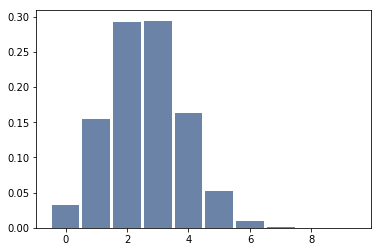

In [4]:
sample = [dinner_party(4, 6, 0.5, 0.1) for i in range(100000)]
pmf_sample = Pmf(sample)
thinkplot.Hist(pmf_sample)

Next, I will solve it with convolution. This one will actually be accurate and correct, though considering how many times I ran the simulation, it shouldn't be far off.

In [5]:
def guest(p):
    """Where 1 means the guest sneezed, and 0 means they did not. This function shamelessly stolen from the dungeons
    prior setup, as were many others.
    """
    return Pmf({1:p, 0:1-p})

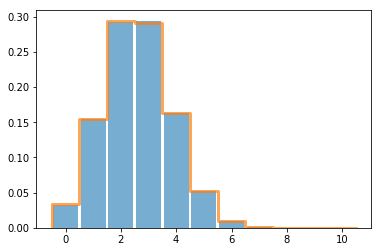

In [6]:
guest_list = ([guest(0.5)]*4)+([guest(0.1)]*6)
dinner_party = sum(guest_list)
thinkplot.Hist(pmf_sample, color='C0')
thinkplot.Pmf(dinner_party, color='C1')

It looks like my simulatiom was pretty accurate. Nice.

## Gluten Problem

I am going to assume that a uniform prior is safe, even though technically the chances of each subject being sensitive probably aren't 50/50. 

In [7]:
class experiment(Suite):
    
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.
        
        data: notices symptoms or does not notice symptoms
        hypo: sensitive or not sensitive
        """
        if data == 'y':
            return 0.95 if hypo == 1 else 0.4
        else:
            return 0.05 if hypo == 1 else 0.6

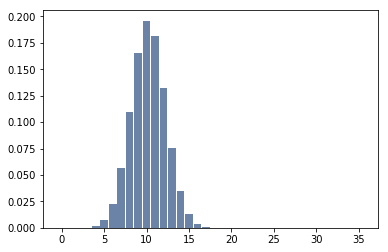

In [8]:
prior = experiment([1,0]) #1 for sensitive vs 0 for not
subject_n = prior.Copy()
subject_y = prior.Copy()
subject_n.Update('n')
subject_y.Update('y')

subjects = [subject_y]*12+[subject_n]*23
full_experiment = sum(subjects)
thinkplot.Hist(full_experiment)

In [9]:
full_experiment.MAP()

10

In [10]:
full_experiment.Mean()

10.213675213675161

In [11]:
full_experiment.CredibleInterval(90)

(7, 14)

Working with the numbers we were given, then, it seems pretty likely that about a third (but a little less) of subjects guessed that the flour contained gluten because of genuine sensitivity. Varying the numbers of course changes this distribution, but not by as much as you would expect.

## Height Problem

I spent a while trying to figure out how to get a probability density function given a mean and a standard distribution. Turns out, that's literally just how this library makes them. Awesome. First, we will make our two height probability density functions, which will be used to compute likelihood.

6.967081088855764e-05

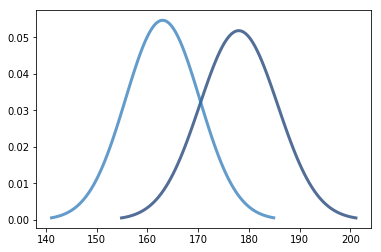

In [12]:
m_heightfunc = NormalPdf(178, 7.7)
f_heightfunc = NormalPdf(163, 7.3)
thinkplot.plot(m_heightfunc)
thinkplot.plot(f_heightfunc)
m_heightfunc.Density(150)

Then, we need a suite class for our person of unknown gender. The likelihood is updated using the PDF. As explained in class, this is sort of cheating, but also sort of allowed, kind of. 

In [13]:
class person(Suite):
    
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.
        
        data: height in cm
        hypo: male or female
        """
        if hypo == 'f':
            return f_heightfunc.Density(data)
        else:
            return m_heightfunc.Density(data)

0.4667199136812651

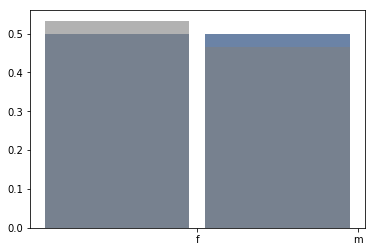

In [14]:
someone = person(['m', 'f'])
thinkplot.Hist(someone)
someone.Update(170)
thinkplot.Hist(someone, color='grey')
someone['m']

So the information that they are 170 cm tall implies that it is slightly more likely that the person is female, with a 46% chance of being male. This makes sense just based on the probably density curves, where for females the curve is slightly higher at 170.

To see the effect of multiple heights on the posterior, we can just define a function which gives us the probablity that a given person is a male based on their height, and then evaluate it at each height in the requested range. The result, interestingly enough, looks kind of like a logistic function.

In [15]:
def find_pmale(height):
    s = person(['m', 'f'])
    s.Update(height)
    return s['m']

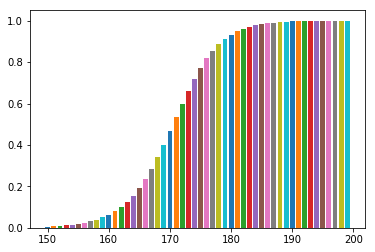

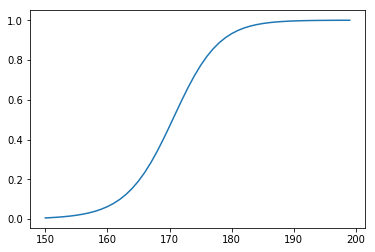

In [16]:
heights = range(150, 200)

#Our traditional bar graph

ps = []
for height in heights:
    pmale = find_pmale(height)
    ps.append(pmale)
    plt.bar(height, pmale)
plt.show()

#For a line, which is a little easier to see
plt.figure()
plt.plot(heights, ps)
plt.show()

## Dungeons and Dragons Problem

First, I will shamelessly use the prior code provided for us.

In [17]:
def coin(p):
    return Pmf({1:p, 0:1-p})
player = coin(0.7)
Party_prior = sum([player]*10)
Party_prior.Print()

0 5.9049000000000085e-06
1 0.00013778100000000018
2 0.0014467005000000017
3 0.009001692000000009
4 0.036756909000000025
5 0.10291934520000004
6 0.20012094900000005
7 0.26682793200000005
8 0.2334744405
9 0.12106082099999994
10 0.028247524899999984


Next, in order to find the likelihood of a given min and max, we need a pmf of the distribution of 3 dice rolls. Computing the probablity of a max is straightforward with this library, I just converted the Pmf to a Cdf, used the max method, then converted back. To get the minimum Pmf, though, I had to work a little harder.

In [18]:
class Die(Pmf):
    def __init__(self, sides):
        Pmf.__init__(self)
        for x in range(1, sides+1):
            self[x]=1/sides
        self.Normalize()

Cdf([ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18], [0.00462963 0.01851852 0.0462963  0.09259259 0.16203704 0.25925926
 0.375      0.5        0.625      0.74074074 0.83796296 0.90740741
 0.9537037  0.98148148 0.99537037 1.        ])

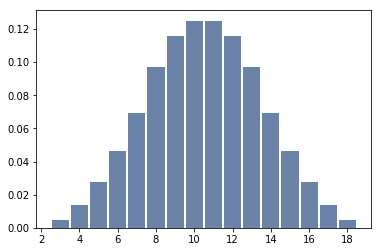

In [19]:
d6 = Die(6)
attribute_dist = sum([d6]*3)
thinkplot.hist(attribute_dist)
attribute_cdf = attribute_dist.MakeCdf()

0.9953703703703703

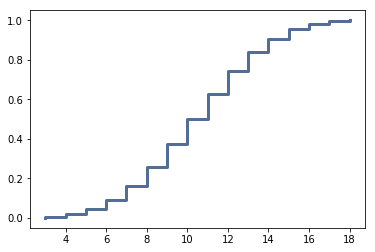

In [20]:
thinkplot.plot(attribute_cdf)
attribute_cdf[17]

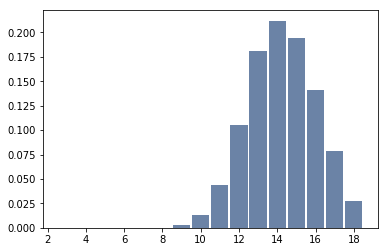

In [22]:
max_cdf = attribute_cdf.Max(6)
max_pmf = max_cdf.MakePmf()
thinkplot.hist(max_pmf)

Ignore the next several cells. I tried to make a reversed Cdf and get a Pmf from it. I was briefly successful (it gave me a mirrored version of the max distribution) but then something changed and the code no longer works.

In [29]:
def make_min_cdf(cdf, k):
    """Gives the minimum of a backwards Cdf, but not backwards in a very good way. This one is kinda weird, its like,
    the chances that the value are greater than x, not greater than or equal to.
    """
    new_cdf = cdf.Copy()
    new_cdf.ps = reversed([(p)**k for p in cdf.ps])
    return cdf

In [30]:
min_cdf = make_min_cdf(attribute_cdf, 6)

Cdf([ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18], [0.00462963 0.01851852 0.0462963  0.09259259 0.16203704 0.25925926
 0.375      0.5        0.625      0.74074074 0.83796296 0.90740741
 0.9537037  0.98148148 0.99537037 1.        ])

In [31]:
def make_min_pmf(min_cdf):
    """Turns my terrible pseudo cdf into a pmf
    """
    min_pmf = Pmf()
    for x in min_cdf.xs:
        min_pmf[x] = min_cdf[x-1]-min_cdf[x]
    min_pmf[min_cdf.xs[0]] = 1 - min_cdf[min_cdf.xs[0]] #Not sure I need this line but I got nervous
    return min_pmf
        

1.1102230246251565e-16

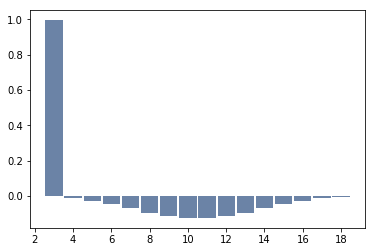

In [32]:
min_pmf = make_min_pmf(min_cdf)
thinkplot.Hist(min_pmf)

#proof of concept, seems to work.
total=0
for i in range(2, 19):
    total += min_pmf[i]
total

Now, I can define a subclass with a likelihood function. I can use the cdf.Max method to get the likelihood of a given number being the maximum, and mirror it across the vertical line at 10.5 to get the minimum.

In [33]:
class Party(Suite):
    def Likelihood(self, data, hypo):
        """
        data: (min, max)
        hypo: number of players
        returns likelihood of the data under the hypothesis
        """
        if hypo < 3:
            return 0
        
        mn, mx = data
        
        diff = mn-3
        equ_max = 18-diff
        max_pmf = attribute_cdf.Max(6*hypo).MakePmf()
        
        #Remnants of my attempt to write code
        #min_cdf = make_min_cdf(attribute_cdf, 6*hypo)
        #min_pmf = make_min_pmf(min_cdf)
        
        pmax = max_pmf[mx]
        pmin = max_pmf[equ_max]
        
        return pmin*pmax

Now I need to make my weird party subclass have the same prior, then just update it.

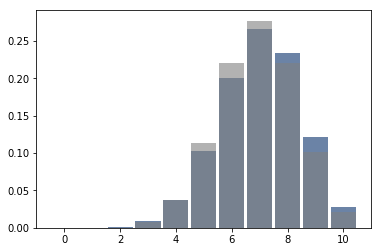

In [34]:
party_post = Party()
for i in range(0, 11):
    party_post[i] = Party_prior[i]
thinkplot.Hist(Party_prior)
data = (5, 16)
party_post.Update(data)
thinkplot.Hist(party_post, color='grey')

This somewhat underwhelming update suggest that seven is still probably the most likely number of players who showed up.